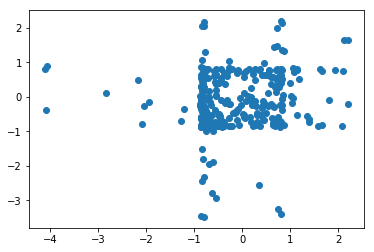

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_tasks(p=0.5, d=100, c=1, n=300, alphas=[], betas=[]):
    '''
    d: dimensionality
    c: scaling factor
    p: correlation
    n: number of data points
    '''
    assert d >= 2, "at least 2 dimension"    
    u1, u2 = np.zeros(d), np.zeros(d)
    u1[0] = 1
    u2[1] = 1
    w1 = c * u1
    w2 = c * (p * u1 + np.sqrt(1-p**2) * u2)
    
    X = []
    Y1 = []
    Y2 = []
    for _ in range(n):
        x = np.random.normal(0, 1, d)
        y1 = w1.dot(x) + np.random.normal(0,0.01)
        y2 = w2.dot(x) + np.random.normal(0,0.01)
        for a, b in zip(alphas, betas):
            y1 += np.sin(a * w1.dot(x) + b)
            y2 += np.sin(a * w2.dot(x) + b)
            
        X.append(x)
        Y1.append(y1)
        Y2.append(y2)
    return np.vstack(X), np.array(Y1), np.array(Y2)

X, Y1, Y2 = generate_tasks(p=0,c=1,alphas=[1,2],betas=[3,4])

plt.scatter(Y1, Y2)
#plt.xlim(-5, 5)
#plt.ylim(-5, 5)
plt.show()

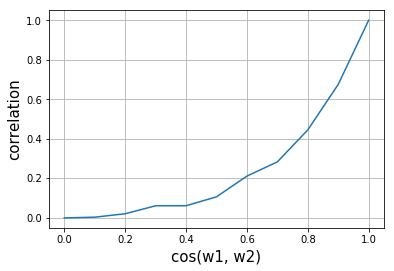

In [2]:
corr = []
pspace = np.linspace(0,1,11)
for p in pspace:
    X, Y1, Y2 = generate_tasks(p=p, n=10000,
                               c=1,
                               alphas=[1,2],
                               betas=[3,4])
    corr.append(np.corrcoef(Y1, Y2)[0,1])
    
plt.plot(pspace, corr)
plt.ylabel('correlation', fontsize=15)
plt.xlabel('cos(w1, w2)', fontsize=15)
plt.grid()
plt.show()

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader  
from torch.utils.data import Dataset

class CosDataset(Dataset):
    
    def __init__(self, p=0.5, d=100, c=1, n=300, alphas=[], betas=[]):
        '''
        d: dimensionality
        c: scaling factor
        p: correlation
        n: number of data points
        '''
        self.X, self.Y1, self.Y2 = generate_tasks(p=p,d=d,c=c,n=n,
                                                  alphas=alphas,betas=betas)
        self.X = torch.from_numpy(self.X).float()
        
    def __len__(self):
        return len(self.Y1)
    
    def __getitem__(self, idx):
        return self.X[idx], (self.Y1[idx], self.Y2[idx])
    
    
def MTL_loss():
    
    def c(yhat, y):
        # regression loss on 2 tasks
        y1, y2 = y
        yhat1, yhat2 = yhat
        c_ = torch.nn.MSELoss()
        return c_(yhat1.view(-1), y1.float().view(-1)) + c_(yhat2.view(-1), y2.float().view(-1))
        
    return c


In [6]:
from torch.utils.data import DataLoader
cos_sim = 0
n = 10000
alphas = [1, 2]
betas = [3, 4]
train_data = DataLoader(CosDataset(p=cos_sim, n=n, alphas=alphas, betas=betas), batch_size=min(1000, n))
val_data = DataLoader(CosDataset(p=cos_sim, n=n, alphas=alphas, betas=betas), batch_size=min(1000, n))

## RK4 optimizer

In [292]:
from torch.optim import Optimizer
from torch.optim.optimizer import required
import math 
from lib.optimizer import RK4, DoublingRK4, Diff, DiffMax, AdamUnbiased, DiffUnbiased

In [294]:
from lib.train import TrainFeedForward
from lib.model import Independent, SharedBottom, MMOE
torch.set_num_threads(1)

optimizers = [
    #torch.optim.Adam,
    #torch.optim.Adadelta,
    #torch.optim.Adamax,
    #torch.optim.ASGD,
    #torch.optim.SGD,
    #RK4,
    #DoublingRK4,
    #Diff,
    DiffUnbiased,
    #AdamUnbiased,
    #DiffMax, # slows down 
]

trainers = []
for opt in optimizers:
    net = Independent(1)
    #net = SharedBottom(3)
    optimizer = opt(net.parameters(), lr=1e-3)
    opt_name = opt.__name__
    print(opt_name)
    
    t = TrainFeedForward(net, train_data, val_data=val_data, criterion=MTL_loss(), n_iters=1000,
                         save_filename='optimizers/{}.pth.tar'.format(opt_name), n_save=30, optimizer=optimizer)
    trainers.append(t)
    t.train()

per layer neuron: 68
DiffUnbiased
          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
==> evaluating validation loss
==> validation loss is 1.491
             10|             1%|          0m 0s|        0.04013|        0.01336|        1.40488
             20|             2%|          0m 0s|        0.02739|        0.00968|        1.38841
             30|             3%|          0m 0s|        0.02299|        0.00845|        1.37167
==> evaluating validation loss
==> validation loss is 1.351
             40|             4%|          0m 1s|        0.02225|        0.00820|        1.35036
             50|             5%|          0m 1s|        0.02074|        0.00785|        1.32131
             60|             6%|          0m 1s|        0.01961|        0.00754|        1.28614
==> evaluating validation loss
==> validation loss is 1.029
             70|             7%|          0m 1s|        0.01954|        0.00792|        1.24311
             80|  

per layer neuron: 68
=> loading checkpoint 'optimizers/SGD.pth.tar'
=> loaded checkpoint 'optimizers/SGD.pth.tar' (iteration 1001)
per layer neuron: 68
=> loading checkpoint 'optimizers/AdamUnbiased.pth.tar'
=> loaded checkpoint 'optimizers/AdamUnbiased.pth.tar' (iteration 1001)
per layer neuron: 68
=> loading checkpoint 'optimizers/Adamax.pth.tar'
=> loaded checkpoint 'optimizers/Adamax.pth.tar' (iteration 1001)
per layer neuron: 68
=> loading checkpoint 'optimizers/DiffUnbiased.pth.tar'
=> loaded checkpoint 'optimizers/DiffUnbiased.pth.tar' (iteration 1001)
per layer neuron: 68
=> loading checkpoint 'optimizers/DoublingRK4.pth.tar'
=> loaded checkpoint 'optimizers/DoublingRK4.pth.tar' (iteration 1001)
per layer neuron: 68
=> loading checkpoint 'optimizers/Diff.pth.tar'
=> loaded checkpoint 'optimizers/Diff.pth.tar' (iteration 1001)
per layer neuron: 68
=> loading checkpoint 'optimizers/Adam.pth.tar'
=> loaded checkpoint 'optimizers/Adam.pth.tar' (iteration 1001)


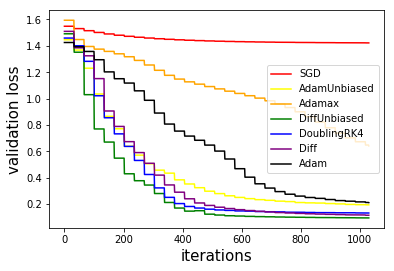

In [295]:
def loadTrainer(loadname, net):
    t = TrainFeedForward(net,
                         DataLoader(CosDataset(1)))
    t.load_checkpoint(loadname)
    return t

colors = ['r', 'yellow', 'orange', 'g', 'blue', 'purple', 'k', 'pink', 'brown', 'cyan']
i = 0
for fn in glob.glob('optimizers/*.tar'):
    k = fn.split('/')[-1].split('.')[0]  
    if 'best' not in fn and k in ['Adam', 'Diff', 'AdamUnbiased', 'SGD', 'Adamax', 'DoublingRK4', 'DiffUnbiased']:
        net = Independent(1)
        t = loadTrainer(fn, net)
        plt.plot(t.val_losses, label=k, color=colors[i])
        i+=1
        
plt.legend()
plt.xlabel('iterations', fontsize=15)
plt.ylabel('validation loss', fontsize=15)
plt.savefig('')
plt.show()

In [321]:
import glob
res = {}
cos_sim = 0.0 # 0.0 0.2 0.4 0.6 0.8 1.0
alpha = 1.0 # 0.1 0.5 1.0
for i in range(1,11):
    for fn in glob.glob('independent3/{}/c={}/a={}/*'.format(i, cos_sim, alpha)):
        if 'best' not in fn:
            net = Independent(3) #SharedBottom(4)
            t = loadTrainer(fn, net)
            
            opt_name = fn.split('/')[-1].split('.')[0]
            if res.get(opt_name) is not None:
                res[opt_name].append(t.val_losses)
            else:
                res[opt_name] = [t.val_losses]

per layer neuron: 45
=> loading checkpoint 'independent3/1/c=0.0/a=1.0/DiffMax.pth.tar'
=> loaded checkpoint 'independent3/1/c=0.0/a=1.0/DiffMax.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'independent3/1/c=0.0/a=1.0/SGD.pth.tar'
=> loaded checkpoint 'independent3/1/c=0.0/a=1.0/SGD.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'independent3/1/c=0.0/a=1.0/AdamUnbiased.pth.tar'
=> loaded checkpoint 'independent3/1/c=0.0/a=1.0/AdamUnbiased.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'independent3/1/c=0.0/a=1.0/Adamax.pth.tar'
=> loaded checkpoint 'independent3/1/c=0.0/a=1.0/Adamax.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'independent3/1/c=0.0/a=1.0/DiffUnbiased.pth.tar'
=> loaded checkpoint 'independent3/1/c=0.0/a=1.0/DiffUnbiased.pth.tar' (iteration 1001)
per layer neuron: 45
=> loading checkpoint 'independent3/1/c=0.0/a=1.0/DoublingRK4.pth.tar'
=> loaded checkpoint 'independent3/1/c=0.0/

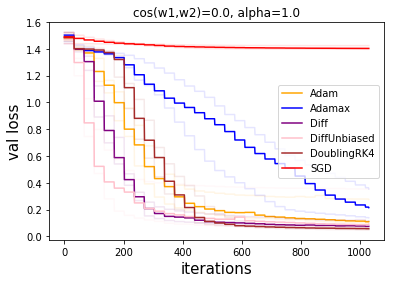

In [322]:
colors = ['red', 'yellow', 'orange', 'g', 'blue', 'purple', 'k', 'pink', 'brown', 'cyan', 'red']
for i, (k, v) in enumerate(sorted(res.items(),key=lambda a: a[0])):
    if k in ['Adam', 'Diff', #'AdamUnbiased',
             'SGD', 'Adamax', 'DoublingRK4', 'DiffUnbiased']:
        try:
            plt.plot(np.percentile(v, 50, 0), label=k, c=colors[i])
            plt.plot(np.percentile(v, 25, 0), alpha=0.1, c=colors[i])
            plt.plot(np.percentile(v, 75, 0), alpha=0.1, c=colors[i])
        except:
            print(k, len(v))

plt.legend()
plt.ylabel('val loss', fontsize=15)
plt.xlabel('iterations', fontsize=15)
plt.title('cos(w1,w2)={}, alpha={}'.format(cos_sim, alpha))
#plt.savefig('opt_figures/p={},a={}.png'.format(cos_sim, alpha))
plt.show()
